In [227]:
import pandas as pd
import os, sys, pickle, itertools
import ujson, re
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE
from operator import itemgetter

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
%matplotlib inline

In [6]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [7]:
data_directory = DATA_ROOT

In [57]:
train_df = pd.read_csv(os.path.join(STORE_LOCATION, 'train.csv'))

In [58]:
test_df = pd.read_csv(os.path.join(STORE_LOCATION, 'test.csv'))

In [10]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [59]:
pdf = post_reader._df

q_tags_df = pdf[pdf.PostTypeId==1][['Id', 'Tags']]

train_df = train_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

test_df = test_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [60]:
train_df[['QuestionId', 'AcceptedAnswerUserId', 'UsersSorted', 'Tags']].head()

,QuestionId,AcceptedAnswerUserId,UsersSorted,Tags
0,5.0,45.0,"[45.0, 1102.0, 48.0, 226.0, 242.0]","[elementary-number-theory, proof-writing, radi..."
1,1.0,8.0,"[8.0, 49.0, 25.0, 35.0, 39.0]","[elementary-set-theory, intuition, faq]"
2,8.0,38.0,"[38.0, 173.0, 334.0, 53.0, 55.0]","[linear-algebra, combinatorics, generating-fun..."
3,2.0,34.0,"[34.0, 56.0, 35.0, 190287.0, 72.0]","[calculus, limits, definition]"
4,20.0,38.0,"[38.0, 72.0, 232.0, 51.0, 210.0]","[terminology, definition, number-systems]"


In [61]:
indx2tag_dict = {}
tag2index_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        indx2tag_dict[float(v.strip())] = k
        tag2index_dict[k] = float(v.strip())

In [62]:
itrain_df = train_df.copy()

val_df = train_df.iloc[11000:]

train_df = train_df.iloc[:11000]

In [25]:
# print model.syn0[model.vocab['10000958'].index].shape
# print model.index2word[169]

In [68]:
val_df.shape

(4796, 7)

In [26]:
def get_user_vals(users):
    return re.findall(r'[{]*(\d+).0', users)

In [27]:
def get_rep(row, model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags]
    w2v_idx = [model.vocab[t].index for t in tag_id]
    t_vectors = model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in model.vocab:
            user_w2v_idx = model.vocab[user].index
            user_vector = model.syn0[user_w2v_idx]
        else:
            user_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [28]:
def get_accuracy(preds, Y):
    pr, tr = [], []
    for i in range(0, preds.shape[0] ,5):
        pr.append(np.argmax(preds[i:i+5]))
        tr.append(np.argmax(Y[i:i+5]))

    pr = np.array(pr)
    tr = np.array(tr)
    
    return (pr==tr).sum()* 1. / pr.shape[0] 

In [32]:
def get_mrr(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)

    return np.mean(1. / np.array(ranks))

In [29]:
# temp = get_rep(train_df.ix[0], model)

In [30]:
ut_files = [f for f in os.listdir(emb_root) if 'ut' in f]

In [31]:
uu_files = [f for f in os.listdir(emb_root) if 'uu' in f]

In [33]:
for emb_file in ut_files:
    model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds, val_ds = [], []
    for indx, row in train_df.iterrows():
        temp_set = get_rep(row, model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    for indx, row in val_df.iterrows():
        temp_set = get_rep(row, model)
        val_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    val_ds = np.vstack(val_ds)
    
    print '\nBegin train'
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(train_ds[:, :256], train_ds[:, 256])
    preds = clf.predict_proba(val_ds[:, :256])[:, 1]
    score = get_accuracy(preds, val_ds[:, 256])
    mrr = get_mrr(preds, val_ds[:, 256])

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : acc - {2}; mrr - {3}'.format(p, q, score, mrr)

Loaded ut_p0.25-q0.25.emb

................
Begin train
p0.25; q0.25 : acc - 0.374687239366; mrr - 0.617417292188
Loaded ut_p0.25-q0.50.emb

................
Begin train
p0.25; q0.50 : acc - 0.374478732277; mrr - 0.616972477064
Loaded ut_p0.25-q1.emb

................
Begin train
p0.25; q1 : acc - 0.388448707256; mrr - 0.626661106478
Loaded ut_p0.25-q2.emb

................
Begin train
p0.25; q2 : acc - 0.379482902419; mrr - 0.619596191271
Loaded ut_p0.25-q4.emb

................
Begin train
p0.25; q4 : acc - 0.383236030025; mrr - 0.62228940784
Loaded ut_p0.50-q0.25.emb

................
Begin train
p0.50; q0.25 : acc - 0.371351125938; mrr - 0.614724075619
Loaded ut_p0.50-q0.50.emb

................
Begin train
p0.50; q0.50 : acc - 0.380108423686; mrr - 0.621232971921
Loaded ut_p0.50-q1.emb

................
Begin train
p0.50; q1 : acc - 0.376772310259; mrr - 0.617493744787
Loaded ut_p0.50-q2.emb

................
Begin train
p0.50; q2 : acc - 0.375312760634; mrr - 0.619363358354
Loade

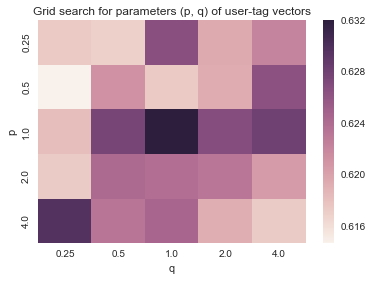

In [40]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.374687239366, 0.617417292188), (0.25, 0.50, 0.374478732277, 0.616972477064), 
                        (0.25, 1, 0.388448707256, 0.626661106478), (0.25, 2, 0.379482902419, 0.619596191271), 
                        (0.25, 4, 0.383236030025, 0.62228940784), (0.50, 0.25, 0.371351125938, 0.614724075619), 
                        (0.50, 0.50, 0.380108423686, 0.621232971921), (0.50, 1, 0.376772310259, 0.617493744787), 
                        (0.50, 2, 0.375312760634, 0.619363358354), (0.50, 4, 0.388657214345, 0.626511676397), 
                        (1, 0.25, 0.377189324437, 0.6182235196), (1, 0.50, 0.390742285238, 0.62761676397), 
                        (1, 1, 0.39845704754, 0.632082290798), (1, 2, 0.389491242702, 0.626890464276), 
                        (1, 4, 0.392410341952, 0.628120656102), (2, 0.25, 0.37364470392, 0.617347789825), 
                        (2, 0.50, 0.389908256881, 0.624245899361), (2, 1, 0.388657214345, 0.623846260773), 
                        (2, 2, 0.385946622185, 0.623210314151), (2, 4, 0.379691409508, 0.620496246872), 
                        (4, 0.25, 0.395120934112, 0.629771337225), (4, 0.50, 0.38448707256, 0.623387545177), 
                        (4, 1, 0.38740617181, 0.624596886294), (4, 2, 0.379899916597, 0.619283430637), 
                        (4, 4, 0.374478732277, 0.617358215179)])

perf_df.columns = ['p', 'q', 'Accuracy', 'Mrr']
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Mrr'))
plt.title('Grid search for parameters (p, q) of user-tag vectors')

In [41]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

In [42]:
def get_rep_uu(row, ut_model, uu_model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags if t in tag2index_dict]
    w2v_idx = [ut_model.vocab[t].index for t in tag_id if t in ut_model.vocab]
    t_vectors = ut_model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    accepted_user = str(int(row.AcceptedAnswerUserId))
    user_vec = {}

    output = None
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = str(int(u))
        op_row = None
        
        if user in ut_model.vocab:
            user_w2v_idx = ut_model.vocab[user].index
            user_vector = ut_model.syn0[user_w2v_idx]
        else:
#             print user
            user_vector = np.zeros(128)
            
        if user in uu_model.vocab:
            user_uu_w2v_idx = uu_model.vocab[user].index
            user_uu_vector = uu_model.syn0[user_uu_w2v_idx]
        else:
#             print user, users
            user_uu_vector = np.zeros(128)
        
        if user == accepted_user:
            op_row = np.hstack((q, user_vector, user_uu_vector, 1))
        else:
            op_row = np.hstack((q, user_vector, user_uu_vector, 0))
            
        if output is None:
            output = op_row
        else:
            output = np.vstack((output, op_row))

    return output

In [43]:
# get_rep_uu(train_df.ix[0], ut_model, uu_model).shape

In [44]:
# for indx, row in train_df.iterrows():
#     temp_set = get_rep_uu(train_df.ix[0], ut_model, uu_model)

In [45]:
for emb_file in uu_files:
#     model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, emb_file), binary=False)
    print 'Loaded {}\n'.format(emb_file)
    
    train_ds, val_ds = [], []
    for indx, row in train_df.iterrows():
        temp_set = get_rep_uu(row, ut_model, uu_model)
        train_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    train_ds = np.vstack(train_ds)
    
    for indx, row in val_df.iterrows():
        temp_set = get_rep_uu(row, ut_model, uu_model)
        val_ds.append(temp_set)
        
        if indx % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()

    val_ds = np.vstack(val_ds)
    
    print '\nBegin train'
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(train_ds[:, :384], train_ds[:, 384])
    preds = clf.predict_proba(val_ds[:, :384])[:, 1]
    score = get_accuracy(preds, val_ds[:, 384])
    mrr = get_mrr(preds, val_ds[:, 384])

    p, q = emb_file.replace('.emb', '').replace('ut_', '').split('-')
    print '{0}; {1} : acc - {2}; mrr - {3}'.format(p, q, score, mrr)

Loaded uu_p0.25-q0.25.emb

................
Begin train
uu_p0.25; q0.25 : acc - 0.395954962469; mrr - 0.63320822908
Loaded uu_p0.25-q0.50.emb

................
Begin train
uu_p0.25; q0.50 : acc - 0.400542118432; mrr - 0.63320822908
Loaded uu_p0.25-q1.emb

................
Begin train
uu_p0.25; q1 : acc - 0.394495412844; mrr - 0.629660133445
Loaded uu_p0.25-q2.emb

................
Begin train
uu_p0.25; q2 : acc - 0.386989157631; mrr - 0.6260911871
Loaded uu_p0.25-q4.emb

................
Begin train
uu_p0.25; q4 : acc - 0.390742285238; mrr - 0.629510703364
Loaded uu_p0.50-q0.25.emb

................
Begin train
uu_p0.50; q0.25 : acc - 0.39553794829; mrr - 0.630643591882
Loaded uu_p0.50-q0.50.emb

................
Begin train
uu_p0.50; q0.50 : acc - 0.393452877398; mrr - 0.629138865721
Loaded uu_p0.50-q1.emb

................
Begin train
uu_p0.50; q1 : acc - 0.395329441201; mrr - 0.630925076453
Loaded uu_p0.50-q2.emb

................
Begin train
uu_p0.50; q2 : acc - 0.397206005004; mrr

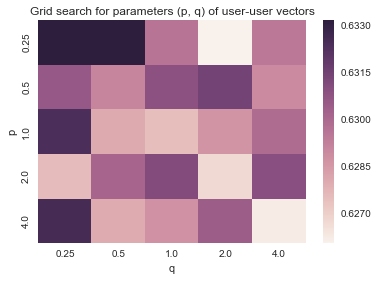

In [46]:
perf_df = pd.DataFrame([(0.25, 0.25, 0.395954962469, 0.63320822908), (0.25, 0.50, 0.400542118432, 0.63320822908), 
                        (0.25, 1, 0.394495412844, 0.629660133445), (0.25, 2, 0.386989157631, 0.6260911871), 
                        (0.25, 4, 0.390742285238, 0.629510703364), (0.50, 0.25, 0.39553794829, 0.630643591882), 
                        (0.50, 0.50, 0.393452877398, 0.629138865721), (0.50, 1, 0.395329441201, 0.630925076453), 
                        (0.50, 2, 0.397206005004, 0.631508896302), (0.50, 4, 0.393452877398, 0.628979010286), 
                        (1, 0.25, 0.397206005004, 0.63245412844), (1, 0.50, 0.391159299416, 0.628037253267), 
                        (1, 1, 0.389491242702, 0.627519460662), (1, 2, 0.393452877398, 0.628676675007), 
                        (1, 4, 0.395954962469, 0.629952043369), (2, 0.25, 0.389699749791, 0.627575062552), 
                        (2, 0.50, 0.394286905755, 0.630202251877), (2, 1, 0.396163469558, 0.631157909369), 
                        (2, 2, 0.38740617181, 0.626761884904), (2, 4, 0.396163469558, 0.630970252989), 
                        (4, 0.25, 0.397623019183, 0.632593133167), (4, 0.50, 0.391159299416, 0.628023352794), 
                        (4, 1, 0.393869891576, 0.628753127606), (4, 2, 0.396163469558, 0.630483736447), 
                        (4, 4, 0.390742285238, 0.626268418126)])

perf_df.columns = ['p', 'q', 'Accuracy', 'Mrr']
ax = sns.heatmap(perf_df.pivot('p', 'q', 'Mrr'))
plt.title('Grid search for parameters (p, q) of user-user vectors')

## Final perf

In [47]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'uu_p0.25-q0.25.emb'), binary=False)

In [69]:
itrain_ds, train_ds, val_ds = [], [], []

for indx, row in itrain_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    itrain_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

itrain_ds = np.vstack(itrain_ds)

print ''

for indx, row in train_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

print ''

for indx, row in val_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    val_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

val_ds = np.vstack(val_ds)

................
...........
.....

In [71]:
test_ds = []
for indx, row in test_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    test_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

test_ds = np.vstack(test_ds)

test_ds.shape

.....

(20730, 385)

## LR

In [73]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :384], train_ds[:, 384])
# preds = clf.predict_proba(val_ds[:, :384])[:, 1]
# print get_accuracy(preds, val_ds[:, 384])
# print get_mrr(preds, val_ds[:, 384])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
preds = clf.predict_proba(train_ds[:, :384])[:, 1]
score = get_accuracy(preds, train_ds[:, 384])
mrr = get_mrr(preds, train_ds[:, 384])
print 'Train scores'
print score, mrr

Train scores
0.429818181818 0.653672727273


In [75]:
preds = clf.predict_proba(val_ds[:, :384])[:, 1]
print get_accuracy(preds, val_ds[:, 384])
print get_mrr(preds, val_ds[:, 384])

0.395954962469
0.63320822908


## GBT

In [77]:
clf = GradientBoostingClassifier(verbose=3)
clf.fit(train_ds[:, :384], train_ds[:, 384])
# preds = clf.predict_proba(val_ds[:, :384])[:, 1]
# print get_accuracy(preds, val_ds[:, 384])
# print get_mrr(preds, val_ds[:, 384])

      Iter       Train Loss   Remaining Time 
         1           0.9852            2.73m
         2           0.9722            2.68m
         3           0.9605            2.63m
         4           0.9511            2.62m
         5           0.9424            2.63m
         6           0.9354            2.62m
         7           0.9289            2.61m
         8           0.9232            2.57m
         9           0.9181            2.55m
        10           0.9137            2.52m
        11           0.9099            2.50m
        12           0.9063            2.48m
        13           0.9031            2.45m
        14           0.9002            2.42m
        15           0.8975            2.40m
        16           0.8951            2.37m
        17           0.8930            2.34m
        18           0.8909            2.31m
        19           0.8888            2.29m
        20           0.8867            2.25m
        21           0.8850            2.23m
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=3, warm_start=False)

In [78]:
preds = clf.predict_proba(train_ds[:, :384])[:, 1]
score = get_accuracy(preds, train_ds[:, 384])
mrr = get_mrr(preds, train_ds[:, 384])
print 'Train scores'
print score, mrr

Train scores
0.476 0.685221212121


In [79]:
preds = clf.predict_proba(val_ds[:, :384])[:, 1]
print get_accuracy(preds, val_ds[:, 384])
print get_mrr(preds, val_ds[:, 384])

0.396997497915
0.631071031415


In [81]:
# itrain_ds.shape

In [82]:
clf = GradientBoostingClassifier(verbose=3)
clf.fit(itrain_ds[:, :384], itrain_ds[:, 384])
# preds = clf.predict_proba(val_ds[:, :384])[:, 1]
# print get_accuracy(preds, val_ds[:, 384])
# print get_mrr(preds, val_ds[:, 384])

      Iter       Train Loss   Remaining Time 
         1           0.9852            4.18m
         2           0.9721            4.16m
         3           0.9612            4.11m
         4           0.9517            4.08m
         5           0.9432            4.07m
         6           0.9361            4.03m
         7           0.9299            3.99m
         8           0.9245            3.96m
         9           0.9196            3.92m
        10           0.9153            3.89m
        11           0.9115            3.85m
        12           0.9082            3.80m
        13           0.9048            3.76m
        14           0.9020            3.71m
        15           0.8995            3.67m
        16           0.8972            3.62m
        17           0.8950            3.57m
        18           0.8928            3.52m
        19           0.8910            3.49m
        20           0.8892            3.45m
        21           0.8875            3.42m
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=3, warm_start=False)

In [85]:
preds = clf.predict_proba(itrain_ds[:, :384])[:, 1]
score = get_accuracy(preds, itrain_ds[:, 384])
mrr = get_mrr(preds, itrain_ds[:, 384])
print 'Train scores'
print score, mrr

Train scores
0.463661686503 0.676385371824


In [86]:
preds = clf.predict_proba(test_ds[:, :384])[:, 1]
print get_accuracy(preds, test_ds[:, 384])
print get_mrr(preds, test_ds[:, 384])

0.483598649301
0.690746100659


In [88]:
max_c = 384

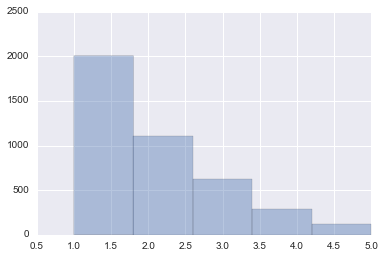

In [294]:
%matplotlib inline
def get_ranks(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)
        
    return ranks

ranks = np.array(get_ranks(preds, test_ds[:, max_c]))

sns.distplot(ranks, kde=False, bins=5)
# plt.title('Rank distribution for test set')

In [92]:
3115./4126

0.7549684924866699

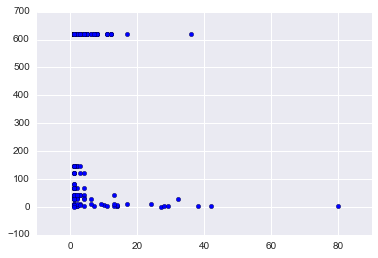

In [97]:
good_questn = np.nonzero(ranks < 3)

bad_questn = np.nonzero(ranks > 3)

# test_df.iloc[bad_questn]

bad_questn_tags = test_df.iloc[bad_questn].Tags.values

tag_cnts = Counter(itertools.chain.from_iterable(bad_questn_tags))

with open('data_temp/tag_clusters.pkl', 'rb') as f:
    tag_clusters = pickle.load(f)

tag_comm_size = {l:len(v) for k,v in tag_clusters.items() for l in v}

tag_comm_size.get('3d', -1)

cnt, size = zip(*[(v, tag_comm_size.get(k, -1)) for k, v in tag_cnts.items()])

plt.scatter(cnt, size)

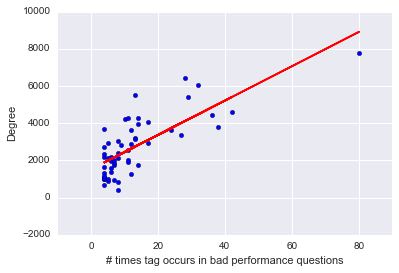

In [98]:
degrees = defaultdict(int)
with open('data_created/graphs/user-tag.txt', 'r') as fl:
    for line in fl.readlines():
        n1, n2 = line.split('\t')
        degrees[float(n1)] += 1
        degrees[float(n2)] += 1



cnt_degrees = [(v, degrees[tag2index_dict[k]]) for k, v in tag_cnts.items() if k in tag2index_dict]

cnt_degrees_rel = filter(lambda x: x[0] > 3, cnt_degrees)
cnt, degree = zip(*cnt_degrees_rel)

slope, c = np.polyfit(cnt, degree, 1)
yfit = np.array(cnt) * slope + c

plt.plot(cnt, yfit, c='r')
plt.scatter(cnt, degree)


# plt.title('Tag count vs. Degree')
plt.ylabel('Degree')
plt.xlabel('# times tag occurs in bad performance questions')

In [308]:
ut_stats = pd.read_csv('/Users/prmathur/Downloads/user-tag-stats.csv')
uu_stats = pd.read_csv('/Users/prmathur/Downloads/user-user-stats.csv')

In [262]:
bad_questn_tags = test_df.iloc[bad_questn].Tags.values
good_questn_tags = test_df.iloc[good_questn].Tags.values

bad_tags = set(itertools.chain.from_iterable(bad_questn_tags))
good_tags = set(itertools.chain.from_iterable(good_questn_tags))

In [263]:
len(bad_tags & good_tags) * 1./ len(bad_tags | good_tags)

0.39019607843137255

In [264]:
ut_stats.head()

,id,label,pageranks,modularity_class,authority,hub,degree,weighted degree,componentnumber,clustering,triangles,eigencentrality
0,3,3,0.000008,4,0.000165,0.000798,3,3,0,0,0,0.004056
1,10000080,10000080,0.008514,4,0.150974,0.031220,5402,5402,0,0,0,0.777964
2,10000719,10000719,0.002981,2,0.076904,0.015903,2189,2189,0,0,0,0.376699
3,10000949,10000949,0.000374,1,0.020572,0.004254,329,329,0,0,0,0.091010
4,5,5,0.000008,3,0.000140,0.000679,3,3,0,0,0,0.003476


In [265]:
good_tags_id = [tag2index_dict[k] for k in good_tags if k in tag2index_dict]
bad_tags_id = [tag2index_dict[k] for k in bad_tags if k in tag2index_dict]

In [270]:
print len(good_tags_id), len(bad_tags_id)

471 220


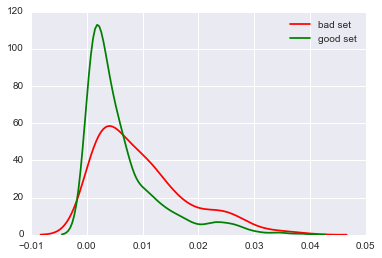

In [268]:
%matplotlib inline
good_tags_hub = ut_stats[ut_stats.id.isin(good_tags_id)]['hub'].values
bad_tags_hub = ut_stats[ut_stats.id.isin(bad_tags_id)]['hub'].values

sns.kdeplot(bad_tags_hub, c='r', label='bad set')
sns.kdeplot(good_tags_hub, c='g', label='good set')

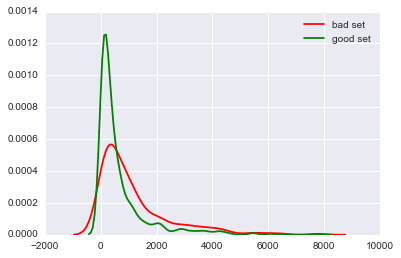

In [269]:
%matplotlib inline
good_tags_deg = ut_stats[ut_stats.id.isin(good_tags_id)]['degree'].values
bad_tags_deg = ut_stats[ut_stats.id.isin(bad_tags_id)]['degree'].values

sns.kdeplot(bad_tags_deg, c='r', label='bad set')
sns.kdeplot(good_tags_deg, c='g', label='good set')

In [271]:
good_tags_id_str = map(lambda x: str(int(x)), good_tags_id)
bad_tags_id_str = map(lambda x: str(int(x)), bad_tags_id)

In [273]:
good_tag_idxs = [ut_model.vocab[v].index for v in good_tags_id_str if v in ut_model.vocab]
bad_tag_idxs = [ut_model.vocab[v].index for v in bad_tags_id_str if v in ut_model.vocab]

In [274]:
pca = PCA(n_components=3)
Y_pca = pca.fit_transform(ut_model.syn0)

In [284]:
# good_pca_tags = Y_pca[good_tag_idxs]
# bad_pca_tags = Y_pca[bad_tag_idxs]

# %matplotlib inline
# plt.scatter(bad_pca_tags[:, 0], bad_pca_tags[:, 1], c='r')
# plt.scatter(good_pca_tags[:, 0], good_pca_tags[:, 1], c='g')

In [283]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(bad_pca_tags[:, 0], bad_pca_tags[:, 1], bad_pca_tags[:, 2], c='r')
# ax.scatter(good_pca_tags[:, 0], good_pca_tags[:, 1], good_pca_tags[:, 2], c='g')
# plt.draw()

In [113]:
# tag_cnts = Counter(itertools.chain.from_iterable(good_questn_tags))

# cnt_degrees = [(v, degrees[tag2index_dict[k]]) for k, v in tag_cnts.items() if k in tag2index_dict]

# cnt_degrees_rel = filter(lambda x: x[0] > 3, cnt_degrees)
# cnt, degree = zip(*cnt_degrees_rel)

# slope, c = np.polyfit(cnt, degree, 1)
# yfit = np.array(cnt) * slope + c

# plt.plot(cnt, yfit, c='r')
# plt.scatter(cnt, degree)


# # plt.title('Tag count vs. Degree')
# plt.ylabel('Degree')
# plt.xlabel('# times tag occurs in bad performance questions')

In [297]:
bad_q_acc_users = test_df.iloc[bad_questn]['AcceptedAnswerUserId'].values
good_q_acc_users = test_df.iloc[good_questn]['AcceptedAnswerUserId'].values

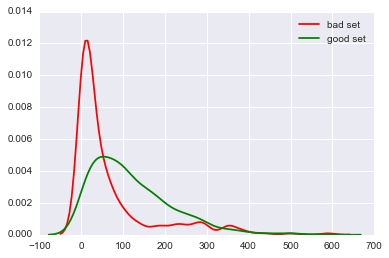

In [299]:
%matplotlib inline
good_u_deg = ut_stats[ut_stats.id.isin(good_q_acc_users)]['degree'].values
bad_u_deg = ut_stats[ut_stats.id.isin(bad_q_acc_users)]['degree'].values

sns.kdeplot(bad_u_deg, c='r', label='bad set')
sns.kdeplot(good_u_deg, c='g', label='good set')

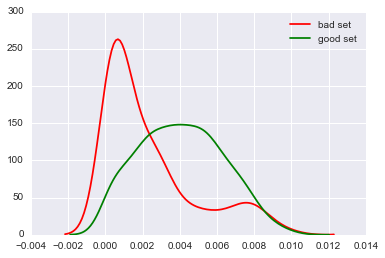

In [307]:
%matplotlib inline
good_u_scr = ut_stats[ut_stats.id.isin(good_q_acc_users)]['authority'].values
bad_u_scr = ut_stats[ut_stats.id.isin(bad_q_acc_users)]['authority'].values

sns.kdeplot(bad_u_scr, c='r', label='bad set')
sns.kdeplot(good_u_scr, c='g', label='good set')

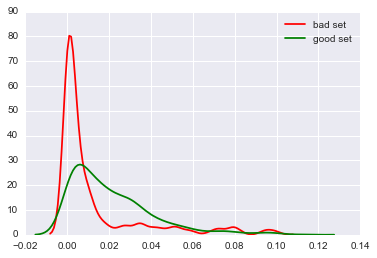

In [311]:
%matplotlib inline
good_u_scr = uu_stats[uu_stats.id.isin(good_q_acc_users)]['authority'].values
bad_u_scr = uu_stats[uu_stats.id.isin(bad_q_acc_users)]['authority'].values

sns.kdeplot(bad_u_scr, c='r', label='bad set')
sns.kdeplot(good_u_scr, c='g', label='good set')